# Baseball Career Arc
### by: Darren Liu

### Objective
> I want to look at the development of a batter through his career. This is motivated by PECOTA, invented by Nate Silver in 2003, as a sophisticated method of forecasting player output for the upcoming season. I intend to perform a simplified version of the study and look at batter performance trends as a function of player age. Intuition would lead us to expect a trend of player improvement from a young age, reaching a pinnacle at some point, and a decline henceforth. Batter performance shall be determined by On-Base-Percentage, or OBP, a popular metric in measuring batter value.

### Question
> Is there a consistent relationship between player age and change in performance? If so, what does the relationship look like and how much of an improvement can one expect the inclusion of its consideration to help in terms of forecasting next period performances.

In [1]:
# initial setup
import warnings
warnings.filterwarnings("ignore")

import unicodecsv
import scipy.stats as sts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

%matplotlib inline

In [2]:
# relevant data
master = pd.read_csv('datasets/Master.csv')
batting_dat = pd.read_csv('datasets/Batting.csv')

In [3]:
# check data properties
print "\nIs Intentional Walks (IBB) a subset of Walks (BB):\n"
print all(batting_dat.dropna(0, 'any')['BB'] >= batting_dat.dropna(0, 'any')['IBB'])
print "\n"

# Find keys for player stats table
print "\nShow non-unique observations under grouping player-year-team-stint\n"
print batting_dat.groupby(['playerID', 'yearID', 'teamID', 'stint']).filter(lambda x: len(x) > 1).head()


Is Intentional Walks (IBB) a subset of Walks (BB):

True



Show non-unique observations under grouping player-year-team-stint

Empty DataFrame
Columns: [playerID, yearID, stint, teamID, lgID, G, AB, R, H, 2B, 3B, HR, RBI, SB, CS, BB, SO, IBB, HBP, SH, SF, GIDP]
Index: []

[0 rows x 22 columns]


### Data Wrangling

Some observations and intuitions form the following tasks to complete and how I anticipate to deal with them:

#### Form new variables of interest

> On Base Percentage (OBP) is a measure of how often a batter reaches base. It is approximately equal to Times on Base/Plate appearances. The full formula is:
>
> $$ On\,Base\,Percentage = \frac{Hits + Walks + Hit\,by\,Pitch}{At\,Bats + Walks + Hit\,by\,Pitch + Sacrifice\,Flies} $$
>
>> The corresponding column names to the stated variables are as such:
>>
>> Hits = H, Walks = BB (IBB is found to be a subset of BB), Hit by pitch = HBP, At Bats = AB, Sacrifice flies = SF

> Change in player performance from year-to-year. It will be measured in nominal terms. Players that miss a season will have change for the following season marked as NaN.

#### Group data by age
> As observed earlier, players can play on multiple teams and its sequence marked by stint. It is probably best to ignore those differences and simply group by player-age since its effect on our choice of response variable is uncertain and most likely trivial. Age is going to be simply defined as year of the data minus player's year of birth

#### Examine anomalies and perhaps remedy them
> It is most likely unexpected problems will arise, although it is best to thoroughly understand data behavior, for the sake of the scope of this assignment I will choose to ignore them if it is not a crime to. 

In [4]:
# batting data
batting_pre_1 = master.merge(batting_dat, on='playerID')[
    ['playerID', 'nameFirst', 'nameLast', 'yearID', 'birthYear', 'H', 'BB', 'HBP', 'AB', 'SF']
]
batting_pre_1['AGE'] = batting_pre_1['yearID'] - batting_pre_1['birthYear']

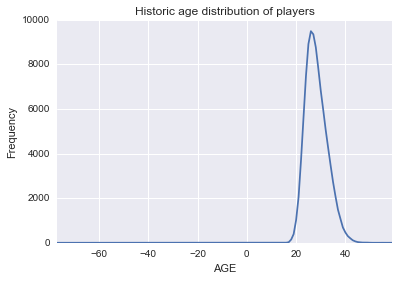

In [5]:
# check data properties
batting_pre_1.groupby('AGE')['playerID'].count().plot(
    title = 'Historic age distribution of players'
)
plt.ylabel('Frequency')

> There are some ages that don't make sense, most obviously the negatives.

In [6]:
# A quick google reveals the historical range of MLB player age to be between 15 and 49 years old
# It is uncertain why the age anomalies exist
# but due to rarity of ocurrence we will simply remove the data points outside of this range
batting_pre_1 = batting_pre_1.loc[batting_pre_1['AGE'].isin(range(16, 49))]

In [7]:
batting_pre_1['NAME'] = batting_pre_1['nameFirst'] + " " + batting_pre_1['nameLast']
batting_pre_2 = batting_pre_1.groupby(['playerID', 'NAME', 'AGE'])[['H', 'BB', 'HBP', 'AB', 'SF']].sum()
# Create new variables
batting_pre_2['OBP'] = batting_pre_2[['H','BB','HBP']].sum(axis=1) / batting_pre_2[['AB','BB','HBP','SF']].sum(axis=1)


Descriptives of OBP before eliminating observations of n < 30

count    79818.000000
mean         0.266744
std          0.136441
min          0.000000
25%          0.200000
50%          0.291815
75%          0.340483
max          1.000000
Name: OBP, dtype: float64


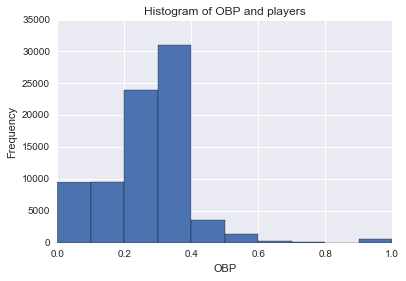

In [8]:
print "\nDescriptives of OBP before eliminating observations of n < 30\n"
print batting_pre_2['OBP'].describe()
batting_pre_2['OBP'].plot(
    kind = 'hist',
    title = "Histogram of OBP and players"
)
plt.xlabel('OBP')

> The span of 0 and 1 OBP covers the entire probability space. The extreme values are most likely a consequence of small sample size. To overcome the problem of unreliable data points, I will choose to only allow player-age data with 30 or more observations. 


In [9]:
# Create weight of observation
batting_pre_2['W'] = batting_pre_2[['AB','BB','HBP','SF']].sum(axis=1)

# Remove data points where sample size (W) is less than 30
batting_pre_3 = batting_pre_2.loc[batting_pre_2['W'] >= 30]


Descriptives of OBP after eliminating observations of n < 30

count    55435.000000
mean         0.297742
std          0.071948
min          0.000000
25%          0.259259
50%          0.309091
75%          0.346431
max          0.609400
Name: OBP, dtype: float64


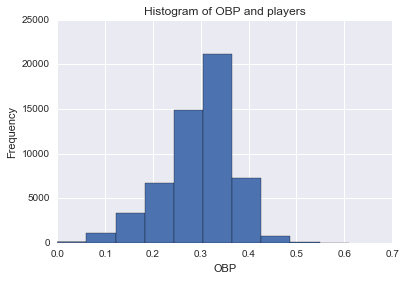

In [10]:
print "\nDescriptives of OBP after eliminating observations of n < 30\n"
print batting_pre_3['OBP'].describe()
batting_pre_3['OBP'].plot(
    kind = 'hist',
    title = "Histogram of OBP and players"
)
plt.xlabel('OBP')

> The sample size filter appears to be a good move. The highly improbable max of 1 has dropped to 0.61. Variability also dropped substantially. The median is relatively unchanged. The distribution now seems to resemble more of a left-skewed distribution

In [11]:
# Create variable of change from previous year
batting_pre_3['CHG'] = batting_pre_3['OBP'] - batting_pre_3.groupby(level=0)['OBP'].shift(1)

In [12]:
# check data properties
# all(batting_pre_3['W'] != 0 | batting_pre_3['OBP'].isnull()) # not necessary after eliminating rows with n < 30
print "\nCheck for NaNs\n"
print "W column has NaN values: " + str(any(batting_pre_3['W'].isnull())) # W has no null values
print "OBP column has NaN values: " + str(any(batting_pre_3['OBP'].isnull())) # OBP has no null values
print "CHG column has NaN values: " + str(any(batting_pre_3['CHG'].isnull())) # CHG has no null values


Check for NaNs

W column has NaN values: False
OBP column has NaN values: False
CHG column has NaN values: True


### Discussion on NA
> Although CHG is shown to have NaN, it is not missing any data. Remember, CHG is a difference variable created by taking the difference of a player-age-OBP at time t and subtracting it from player-age-OBP at time t - 1. Therefore, given we saw that OBP has no null values, the only scenario where CHG has a null value is for the first year of player's career. Below is a confirmation of this fact

In [13]:
print "\nPlayers with NaN\n"
print batting_pre_3[batting_pre_3['CHG'].isnull()].reset_index().playerID.nunique()
print "\nPlayers with more than one NaN\n"
print batting_pre_3[batting_pre_3['CHG'].isnull()].reset_index().groupby('playerID').filter(lambda x: len(x) > 1).head()
print "\nTotal players\n"
print batting_pre_3.reset_index().playerID.nunique()


Players with NaN

10439

Players with more than one NaN

Empty DataFrame
Columns: [playerID, NAME, AGE, H, BB, HBP, AB, SF, OBP, W, CHG]
Index: []

Total players

10439


In [14]:
batting = batting_pre_3.reset_index()[['NAME', 'AGE', 'W', 'OBP', 'CHG']]
print "\nDescriptives of dataset variables\n"
print batting.describe()


Descriptives of dataset variables

                AGE             W           OBP           CHG
count  55435.000000  55435.000000  55435.000000  44996.000000
mean      28.483251    279.578407      0.297742     -0.001008
std        4.256923    212.849438      0.071948      0.057183
min       16.000000     30.000000      0.000000     -0.324876
25%       25.000000     80.000000      0.259259     -0.034033
50%       28.000000    223.000000      0.309091     -0.001520
75%       31.000000    469.000000      0.346431      0.031650
max       48.000000    778.000000      0.609400      0.361574


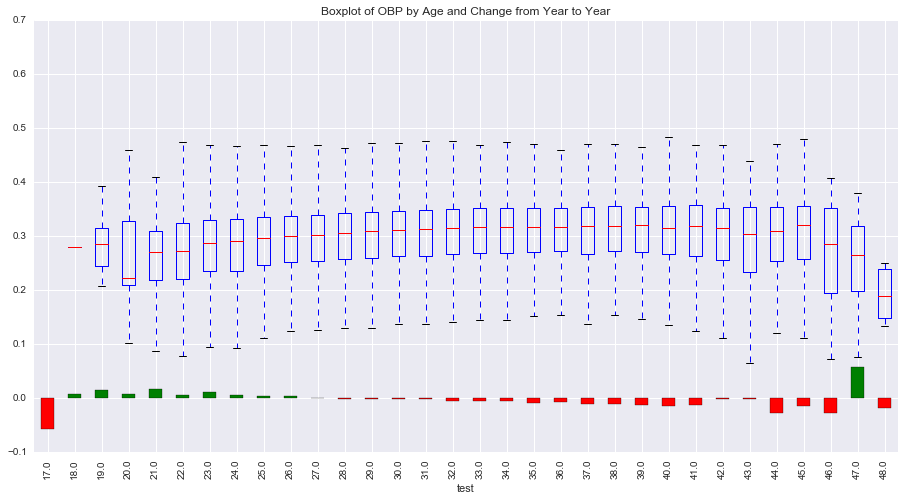

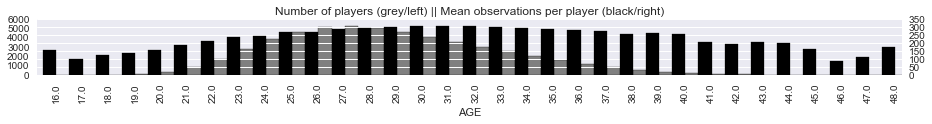

In [15]:
# Exploratory plotting
ax1 = batting.boxplot(
    column='OBP',
    by='AGE',
    figsize=(15, 8)
)

ax1_1 = batting[['AGE', 'CHG']].dropna(0, 'any').groupby(["AGE"]).mean()
ax1_1['COL'] = ax1_1['CHG'] > 0

ax1_1['CHG'].plot(
    kind='bar',
    figsize=(15, 8),
    color=ax1_1.COL.map({True: 'g', False: 'r'}),
    ax=ax1
)

plt.title("Boxplot of OBP by Age and Change from Year to Year")
plt.xlabel('test')
plt.suptitle("")

ax2 = batting[['AGE', 'NAME']].dropna(0, 'any').groupby(["AGE"]).count().plot(
    kind='bar',
    color='grey',
    legend=False,
    figsize=(15, 1),
    position=0
)

batting[['AGE', 'W']].dropna(0, 'any').groupby(["AGE"]).mean().plot(
    kind='bar',
    color='black',
    legend=False,
    figsize=(15.5, 1),
    position=1,
    secondary_y=True,
    ax=ax2
)
plt.title("Number of players (grey/left) || Mean observations per player (black/right)")
plt.suptitle("")

### Exploration
> There is a lot of good information here. The discussion is based on the visualizations from above and numbers from below. The headline here really is that 

>> #### players peak at age 27

> There is a very steady pattern of improvement until age 27 and a equally steady decline from there. There seems to be

>> #### negative performance acceleration from nearly the beginning

> of a player's career. Players start with high levels of improvement, taper off, decline marginally, and decline drastically. Although it would appear from OBP by age group that players peak after 27, I argue that it is because some weaker players who did not pan out by then often depart from the league, thus allowing the average to increase. This theory is supported by the fact that the total number of players begin to decline from age 27.

In [16]:
print "\nDescriptives of dataset variables\n"
print batting[['AGE', 'OBP', 'CHG', 'W']].groupby("AGE").agg(['mean', 'count'])


Descriptives of dataset variables

          OBP             CHG                 W      
         mean count      mean count        mean count
AGE                                                  
16   0.279503     1       NaN     0  161.000000     1
17   0.287905     9 -0.057729     1  102.111111     9
18   0.255808    30  0.007650     6  124.566667    30
19   0.258668   124  0.014940    15  137.258065   124
20   0.269567   378  0.007867    88  155.682540   378
21   0.279868   886  0.017820   275  190.539503   886
22   0.280519  1762  0.005306   710  215.103292  1762
23   0.287112  2844  0.011108  1395  237.448664  2844
24   0.290600  3873  0.005204  2299  246.521301  3873
25   0.292240  4665  0.003852  3209  269.160772  4665
26   0.294405  5226  0.003356  3984  272.840987  5226
27   0.297015  5274  0.000871  4381  287.700986  5274
28   0.299017  5049 -0.001031  4426  294.502674  5049
29   0.300765  4623 -0.001038  4192  299.442137  4623
30   0.302348  4123 -0.002332  3853  307.36260

> Forecasting with and without career arc adjustments is compared. Based on sample size and data stability, the forecast method will attempt to predict next season performance for age groups 20 to 40. The two competing methods are:

>> 1. Basic Forecast - Predict the next season OBP based on current season
>> 2. Adjusted Forecast - Predict the next season OBP based on current season + expected change from career arc

In [17]:
chg = batting[['AGE', 'CHG']].dropna(0, 'any').groupby(["AGE"]).mean()

# subset forecast to ages 20 to 40
forecast = batting[['AGE', 'OBP']].loc[batting['AGE'].isin(range(19, 41))] # 19 because it'll be used to forecast 20

# predictions
forecast['BASIC'] = forecast['OBP'].shift(1)
forecast['ADJ'] = forecast['BASIC'] + chg.loc[batting['AGE'], 'CHG'].reset_index()['CHG']

# error = observed - predicted
forecast['BASIC_ERR'] = forecast['OBP'] - forecast['BASIC']
forecast['ADJ_ERR'] = forecast['OBP'] - forecast['ADJ']

# drop NaN
forecast = forecast.dropna(0, 'any')


Error Descriptives of Basic and Career Arc Adjusted Methods

          BASIC_ERR       ADJ_ERR
count  55066.000000  55066.000000
mean      -0.000003     -0.000171
std        0.068673      0.068504
min       -0.375000     -0.380204
25%       -0.037108     -0.036834
50%       -0.000704     -0.000188
75%        0.036608      0.036504
max        0.516129      0.498309


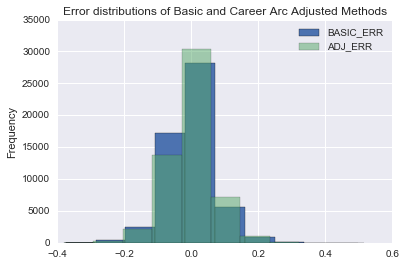

In [18]:
print "\nError Descriptives of Basic and Career Arc Adjusted Methods\n"
print forecast[['BASIC_ERR', 'ADJ_ERR']].describe()

forecast['BASIC_ERR'].plot(
    kind='hist',
    alpha=1,
    legend=True
)
forecast['ADJ_ERR'].plot(
    kind='hist',
    alpha=0.5,
    legend=True,
    title="Error distributions of Basic and Career Arc Adjusted Methods"
)

In [19]:
print "\nRoot Mean Squared Error of Basic and Career Arc Adjusted Methods\n"
print np.sqrt(np.mean(forecast[['BASIC_ERR', 'ADJ_ERR']] ** 2))


Root Mean Squared Error of Basic and Career Arc Adjusted Methods

BASIC_ERR    0.068672
ADJ_ERR      0.068503
dtype: float64


In [20]:
print "\nKruskal-Wallis test for difference in errors\n"
sts.mstats.kruskalwallis(forecast['BASIC_ERR'], forecast['ADJ_ERR'])


Kruskal-Wallis test for difference in errors



KruskalResult(statistic=0.43115972852766704, pvalue=0.51142043517561608)

> A Kruskal-Wallis H test showed that there was not a statistically significant difference in error between the basic forecast and career arc adjusted forecast with χ2 = 0.4312, p = 0.5114.

### Conclusion
> A consistent pattern of player age and change in performance was observed. The evidence points to a performance curve that increases and peaks at age 27 and decreases from there on. The curve has the appearance of an arc due to a decrease in performance velocity over time that is the consequence of negative performance acceleration.

> However, the Kruskal-Wallis test demonstrate that the inclusion of the career arc adjustment does not significantly improve next period forecast performances. This is perhaps so given the oversimplified test design. I am still confident the career arc is a significant element in proper projection of future player performance if used properly. Therefore, a future study can examine alternative model designs that successfully incorporate its use that the current study had no success in doing.

> Thanks for reading!

#### source
> http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas

> http://stackoverflow.com/questions/23198053/how-do-you-shift-pandas-dataframe-with-a-multiindex

> http://blog.th4t.net/get-rid-of-the-automatic-pandas-generated-boxplot-title.html

> http://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis

> http://stackoverflow.com/questions/19384532/how-to-count-number-of-rows-in-a-group-in-pandas-group-by-object

> http://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib